# Librerías

In [188]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
import xarray as xr
import matplotlib.pyplot as plt
import gzip
import shutil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from scipy.interpolate import CubicSpline

# from tensorflow.keras import Sequential, Model, Input
# from tensorflow.keras.layers import  Dense

# Mis utilitarios
from utils import *

# Path

In [189]:
el_path_main = Path(os.getcwd()).parent
el_path_main

WindowsPath('e:/backup Asus G15 27_10_2021/Colegio de Mates Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting')

In [190]:
el_path_main/'2. Datos/Main gridded data'
# .gz es porque es un comprimido
# los .dat son un archivo complicado de leer ya que tenemos que hacer un reshape al array creado en función a la lat, long, tiempo, etc.
# los .dat.nc son más sencillo de leer

WindowsPath('e:/backup Asus G15 27_10_2021/Colegio de Mates Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/2. Datos/Main gridded data')

In [191]:
# Decompress .gz file
sufix = 'dat'

lista_info_files = ['cld', # Cloud Coverage (%)
                    'dtr', # Diurnal 2 m temperature range (degrees Celsius)
                    'frs', # Frost days (days per month)
                    'pet', # Potential evapo-transpiration (mm/day)
                    'pre', # Precipitation rate (mm/month )
                    'tmn', # Minimum 2 m temperature (degrees celsius)
                    'tmp', # Mean 2 m temperature (degrees celsius)
                    'tmx', # Maximum 2 m temperature (degrees celsius)
                    'vap', # Vapour pressure (hPa)
                    'wet'  # Wet days (days)
                    ]

# Decompress

In [192]:
# for file_info in lista_info_files:
#     file_name_ini = el_path_main/f'2. Datos/Main gridded data/cru_ts4.09.1901.2024.{file_info}.{sufix}.nc.gz' 
#     file_name_end = el_path_main/f'2. Datos/Main gridded data/cru_ts4.09.1901.2024.{file_info}.{sufix}.nc'
#     with gzip.open(file_name_ini, 'rb') as f_in:
#         with open(file_name_end, 'wb') as f_out:
#             shutil.copyfileobj(f_in, f_out)

# Load Datasets

In [193]:
files_cargados = {}
for file_info in lista_info_files:
    file_name_nc = el_path_main/f'2. Datos/Main gridded data/cru_ts4.09.1901.2024.{file_info}.dat.nc'
    # Load the dataset
    ds = xr.open_dataset(file_name_nc)
    files_cargados[f'ds_{file_info}'] = ds

C:\Users\Gabri\AppData\Local\Temp\ipykernel_4772\1349768469.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_name_nc)
C:\Users\Gabri\AppData\Local\Temp\ipykernel_4772\1349768469.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_name_nc)


In [194]:
ds_cld = files_cargados['ds_cld']
ds_wet = files_cargados['ds_wet']

In [195]:
ds_cld['lat'].values.shape, ds_cld['lon'].values.shape, ds_cld['time'].values.shape, ds_cld['cld'].values.shape

((360,), (720,), (1488,), (1488, 360, 720))

In [196]:
_lon, _lat = np.meshgrid(ds_cld['lon'].values, ds_cld['lat'].values)

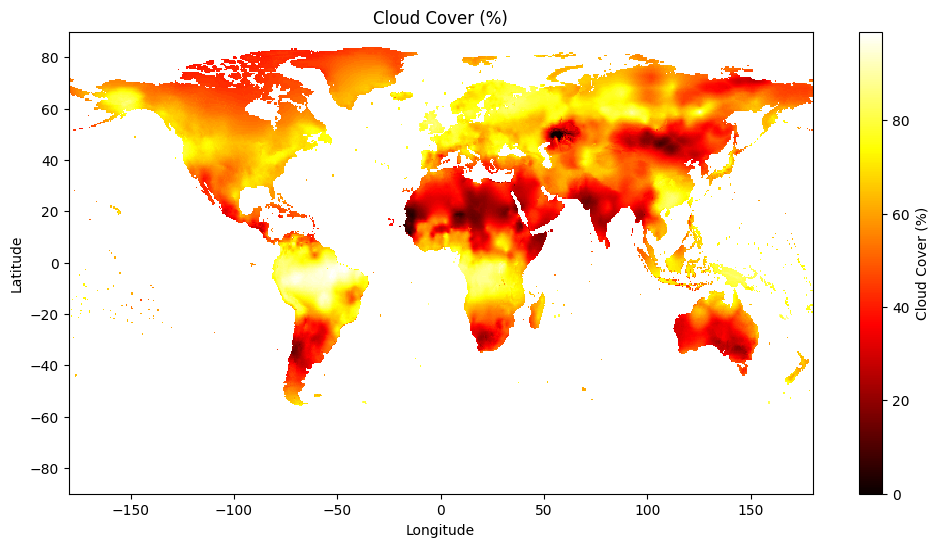

In [197]:
_cld = ds_cld['cld'].values[-10]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon, _lat, _cld, shading='auto', cmap='hot')
plt.colorbar(label='Cloud Cover (%)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cloud Cover (%)')
plt.show()

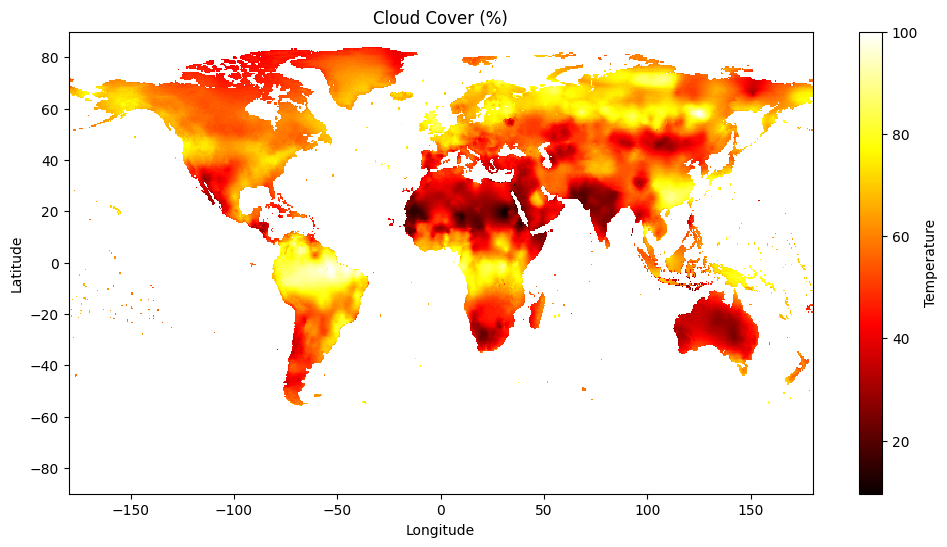

In [198]:
_cld = ds_cld['cld'].values[-9]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon, _lat, _cld, shading='auto', cmap='hot')
plt.colorbar(label='Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cloud Cover (%)')
plt.show()

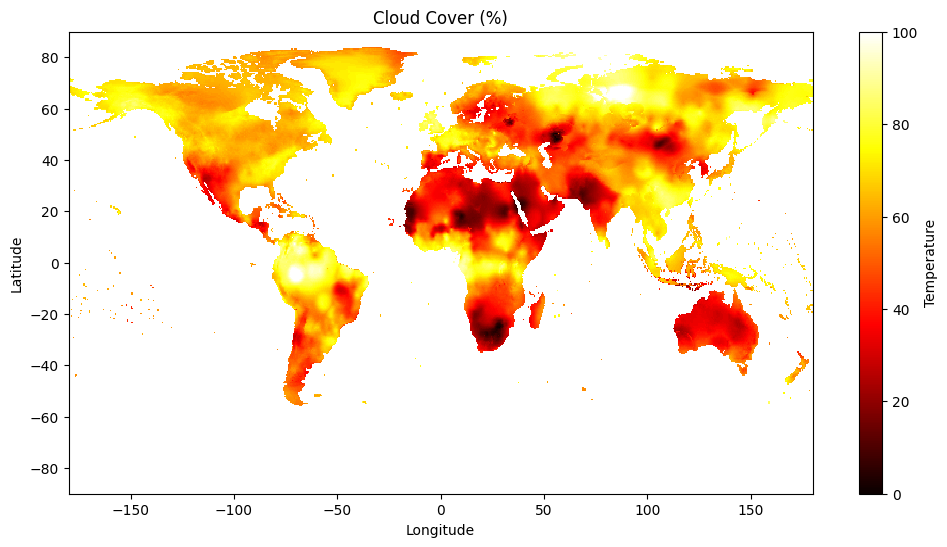

In [199]:
_cld = ds_cld['cld'].values[-8]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon, _lat, _cld, shading='auto', cmap='hot')
plt.colorbar(label='Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cloud Cover (%)')
plt.show()

In [200]:
# Perú parece estar en los rangos (google maps ayudó con esto):
min_lon = -81
max_lon = -68
min_lat = -18
max_lat = 0

In [201]:
rango_index_lon = np.where(
    (ds_cld['lon'].values >= min_lon)&
    (ds_cld['lon'].values <= max_lon)
                           )[0]
desde_index_lon = rango_index_lon[0]
hasta_index_lon = rango_index_lon[-1]

rango_index_lat = np.where(
    (ds_cld['lat'].values >= min_lat)&
    (ds_cld['lat'].values <= max_lat)
                           )[0]
desde_index_lat = rango_index_lat[0]
hasta_index_lat = rango_index_lat[-1]

In [202]:
_lon, _lat = np.meshgrid(ds_cld['lon'].values[desde_index_lon:hasta_index_lon+1], ds_cld['lat'].values[desde_index_lat:hasta_index_lat+1])
datos_cld = ds_cld['cld'].values[-8][desde_index_lat:hasta_index_lat+1, desde_index_lon:hasta_index_lon+1]

In [203]:
datos_cld.shape

(36, 26)

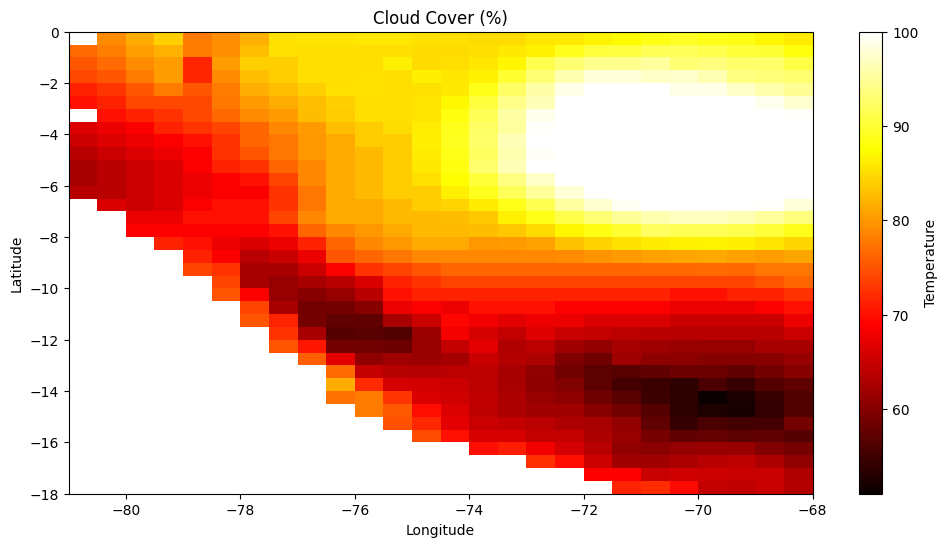

In [204]:

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon, _lat, datos_cld, shading='auto', cmap='hot')
plt.colorbar(label='Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cloud Cover (%)')
plt.show()

# Acotamiento a Perú

In [205]:
def filtrar_por_lat_lon(ds, lat_range, lon_range):
    """
    Filtra el dataset por un rango de latitudes y longitudes.
    
    Args:
        ds (xarray.Dataset): Dataset a filtrar.
        lat_range (tuple): Rango de latitudes (min_lat, max_lat).
        lon_range (tuple): Rango de longitudes (min_lon, max_lon).
        
    Returns:
        xarray.Dataset: Dataset filtrado.
    """
    return ds.sel(lat=slice(*lat_range), lon=slice(*lon_range))

In [206]:
min_lon_LA = -83
max_lon_LA = -35
min_lat_LA = -60
max_lat_LA = 13

In [207]:
ds_cld_peru_prueba = filtrar_por_lat_lon(ds_cld, (min_lat_LA, max_lat_LA), (min_lon_LA, max_lon_LA))
ds_wet_peru_prueba = filtrar_por_lat_lon(ds_wet, (min_lat_LA, max_lat_LA), (min_lon_LA, max_lon_LA))

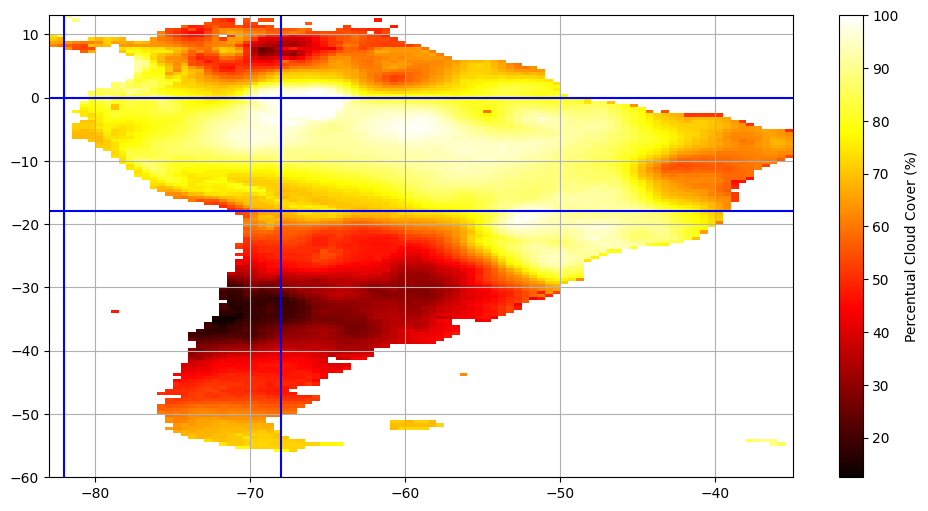

In [208]:
min_lon_candi = -82
max_lon_candi = -68
min_lat_candi = -18
max_lat_candi = 0

_lon_per, _lat_per = np.meshgrid(ds_cld_peru_prueba['lon'].values,
                                 ds_cld_peru_prueba['lat'].values)
_frs_peru = ds_cld_peru_prueba['cld'].values[-1]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon_per, _lat_per, _frs_peru, shading='auto', cmap='hot')
plt.colorbar(label='Percentual Cloud Cover (%)')
plt.grid()

# Superior Izquierdo
plt.axvline(x = min_lon_candi, color = 'b', label = 'axvline - full height')
plt.axhline(y = max_lat_candi, color = 'b', label = 'axvline - full height')

# Inferior Derecho
plt.axvline(x = max_lon_candi, color = 'b', label = 'axvline - full height')
plt.axhline(y = min_lat_candi, color = 'b', label = 'axvline - full height')


In [209]:
# Rangos FINALES
min_lon = min_lon_candi
max_lon = max_lon_candi
min_lat = min_lat_candi
max_lat = max_lat_candi

In [210]:
files_cargados_peru  = {info:filtrar_por_lat_lon(files_cargados[info], (min_lat, max_lat), (min_lon, max_lon)) for info in files_cargados}

# Transformación timedelta into float (ns to days)

In [211]:
def es_miss_array(array):
    el_tipo_de_dato = array.dtype
    if el_tipo_de_dato == 'timedelta64[ns]':
        return np.isnat(array)
    else:
        return np.isnan(array) | np.isinf(array) | (array == -9999)

In [212]:
th_dias = 0.01

In [213]:
el_new_array_wet = files_cargados_peru['ds_wet']['wet'].values.astype('timedelta64[D]').astype('float')
files_cargados_peru['ds_wet']['wet'].values = np.where(el_new_array_wet<=th_dias, np.nan, el_new_array_wet)

el_new_array_frs = files_cargados_peru['ds_frs']['frs'].values.astype('timedelta64[D]').astype('float')
files_cargados_peru['ds_frs']['frs'].values = np.where(el_new_array_frs<=th_dias, np.nan, el_new_array_frs)

In [214]:
files_cargados_peru['ds_wet']

<xarray.Dataset> Size: 36MB
Dimensions:  (lon: 28, lat: 36, time: 1488)
Coordinates:
  * lon      (lon) float32 112B -81.75 -81.25 -80.75 ... -69.25 -68.75 -68.25
  * lat      (lat) float32 144B -17.75 -17.25 -16.75 ... -1.25 -0.75 -0.25
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
Data variables:
    wet      (time, lat, lon) float64 12MB nan nan nan nan ... 25.0 24.0 23.0
    stn      (time, lat, lon) float64 12MB ...
    mae      (time, lat, lon) float32 6MB ...
    maea     (time, lat, lon) float32 6MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Rain Days
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:wet.2503051121.dtb...
    history:      Wed  5 Mar 17:51:19 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

# EDA 

In [215]:
def eda_np_arrays(array, axis = None):
    if axis is None:
        return {
            'mean': np.nanmean(array),
            'std': np.nanstd(array),
            'min': np.nanmin(array),
            'max': np.nanmax(array),
            'median': np.nanmedian(array),
            'non_nan': np.count_nonzero(~np.isnan(array)),
            'nan': np.count_nonzero(np.isnan(array)),
            'ptj_nan': np.count_nonzero(np.isnan(array)) / array.size * 100
        }
    else:
        return {
            'mean': np.nanmean(array, axis=axis),
            'std': np.nanstd(array, axis=axis),
            'min': np.nanmin(array, axis=axis),
            'max': np.nanmax(array, axis=axis),
            'median': np.nanmedian(array, axis=axis),
            'non_nan': np.count_nonzero(~np.isnan(array), axis=axis),
            'nan': np.count_nonzero(np.isnan(array), axis=axis),
            'ptj_nan': np.count_nonzero(np.isnan(array), axis=axis)/ array.shape[axis] * 100
        }

    

In [216]:
files_cargados_peru.keys()

dict_keys(['ds_cld', 'ds_dtr', 'ds_frs', 'ds_pet', 'ds_pre', 'ds_tmn', 'ds_tmp', 'ds_tmx', 'ds_vap', 'ds_wet'])

In [217]:
df_stats = pd.DataFrame()
for i in files_cargados_peru.keys():
    name_var = info_name = re.sub(r'ds_', '', i)
    np_data = files_cargados_peru[i][name_var].values
    resultado = eda_np_arrays(np_data, axis = None)
    df_stats = pd.concat([df_stats, pd.DataFrame(resultado, index=[name_var])], axis=0)

In [218]:
df_stats

,mean,std,min,max,median,non_nan,nan,ptj_nan
cld,73.885323,12.510755,6.5,100.000000,76.300003,1120464,379440,25.297619
dtr,11.730948,2.641748,3.6,27.100000,11.300000,1120464,379440,25.297619
frs,14.062092,8.657527,1.0,31.000000,14.000000,214860,1285044,85.675083
pet,3.050815,0.497870,0.8,6.100000,3.000000,1116000,383904,25.595238
pre,151.145065,121.078117,0.0,1998.000000,141.000000,1120464,379440,25.297619
tmn,15.362081,7.970950,-14.1,26.300001,19.100000,1120464,379440,25.297619
tmp,21.206629,6.986344,-2.3,30.600000,24.900000,1120464,379440,25.297619
tmx,27.097008,6.141308,7.7,36.900002,30.100000,1120464,379440,25.297619
vap,21.469784,8.429457,0.8,33.600002,24.900000,1120464,379440,25.297619
wet,13.827842,7.232925,1.0,31.000000,14.000000,1066518,433386,28.894249


In [219]:
# Notamos que, en general, los missings son iguales en varias de las varaiables, por lo que usaré la existencia de missing como filtro para el caso de la generación de grafos (no me interesan [lat,lon] que sean en el mar sin información)

# Transform data into a GraphFormat

In [220]:
files_cargados_peru.keys()

dict_keys(['ds_cld', 'ds_dtr', 'ds_frs', 'ds_pet', 'ds_pre', 'ds_tmn', 'ds_tmp', 'ds_tmx', 'ds_vap', 'ds_wet'])

In [221]:
las_lon = np.array([files_cargados_peru[el_ds]['lon'].values for el_ds in files_cargados_peru])
las_lat = np.array([files_cargados_peru[el_ds]['lat'].values for el_ds in files_cargados_peru])
los_mes = np.array([files_cargados_peru[el_ds]['time'].values for el_ds in files_cargados_peru])

In [222]:
np.max( np.min(las_lon, axis=0) == np.max(las_lon, axis=0)   )
# Todas las lon son iguales en todos los datasets (El máx es True)

np.True_

In [223]:
np.max( np.min(las_lat, axis=0) == np.max(las_lat, axis=0)   )
# Todas las lat son iguales en todos los datasets (El máx es True)

np.True_

In [224]:
np.max( np.min(los_mes, axis=0) == np.max(los_mes, axis=0)   )
# Todas los meses son iguales en todos los datasets (El máx es True)

np.True_

In [225]:
los_mes[0].shape[0]

1488

In [226]:
a = np.array([1,2,3])
for i in range(a.shape[0]):
    print(a[i])

1
2
3


In [227]:
_los_mes, _las_lat, _las_lon = np.meshgrid(los_mes[0], las_lat[0], las_lon[0], indexing='ij')
lon_for_df = _las_lon.ravel()
lat_for_df = _las_lat.ravel()
mese_for_df = _los_mes.ravel()

consol_df = pd.DataFrame({'time': mese_for_df,
                'lon':lon_for_df,
                'lat':lat_for_df})

for info in files_cargados_peru:
    info_name = re.sub(r'ds_', '', info)
    tmp_df = pd.DataFrame(
                {'time': mese_for_df,
                'lon':lon_for_df,
                'lat':lat_for_df,
                info_name: files_cargados_peru[info][info_name].values.ravel()
                })
    consol_df = pd.concat([consol_df, tmp_df[[info_name]]], axis=1)

In [228]:
_las_lon.shape, _las_lat.shape, _los_mes.shape, files_cargados_peru[info][info_name].values.shape

((1488, 36, 28), (1488, 36, 28), (1488, 36, 28), (1488, 36, 28))

In [229]:
consol_df['CODMES'] = consol_df['time'].dt.strftime('%Y%m').astype(int)
consol_df.drop(columns=['time'], inplace=True)

# Generación de cuadrantes
Esta generación de cuadrantes será usada para armar el target.

## Método lineal

In [230]:
def genera_eq_lat_lon(x_0, x_1):
    """
    Genera una ecuación de latitud y longitud a partir de un punto dado.
    
    Args:
        x_0 (tuple): Tupla con la latitud y longitud del punto de referencia 1. (lon, lat)
        x_1 (tuple): Tupla con la latitud y longitud del punto de referencia 2. (lon. lat)
    Returns:
        tuple: Ecuación de latitud y longitud.
    """
    lon_0, lat_0 = x_0
    lon_1, lat_1 = x_1

    m = (lat_1 - lat_0) / (lon_1 - lon_0)
    b = lat_0 - m * lon_0
    
    def funcion(x):
        return m * x + b

    return funcion, m, b    

In [231]:
descr = consol_df[['lon', 'lat']].describe()
descr

,lon,lat
count,1.499904e+06,1.499904e+06
mean,-7.500000e+01,-9.000000e+00
std,4.038875e+00,5.194149e+00
min,-8.175000e+01,-1.775000e+01
25%,-7.837500e+01,-1.337500e+01
50%,-7.500000e+01,-9.000000e+00
75%,-7.162500e+01,-4.625000e+00
max,-6.825000e+01,-2.500000e-01


In [232]:
descr.loc['min', 'lon'], descr.loc['max', 'lat']

(np.float64(-81.75), np.float64(-0.25))

In [233]:
x_0 = (descr.loc['min', 'lon'], descr.loc['max', 'lat'])
x_1 = (descr.loc['max', 'lon'], descr.loc['min', 'lat'])
print(f'Punto 1: {x_0}, Punto 2: {x_1}')

Punto 1: (np.float64(-81.75), np.float64(-0.25)), Punto 2: (np.float64(-68.25), np.float64(-17.75))


In [234]:
# Si parto la imagen en 2 este sería el uso 
genera_eq_lat_lon(x_0=x_0, x_1=x_1)

(<function __main__.genera_eq_lat_lon.<locals>.funcion(x)>,
 np.float64(-1.2962962962962963),
 np.float64(-106.22222222222221))

In [235]:
# la generación de cuadrantes la voy a armar en 3, costa sierra y selva, y esta diferenciación la haré a través de 2 ecuaciones serán armadas de la forma M*long+B

Para la generación de las div se usa maps con las cordenadas en base a las cuales aprox puedo partir el Perú en costa sierra y selva
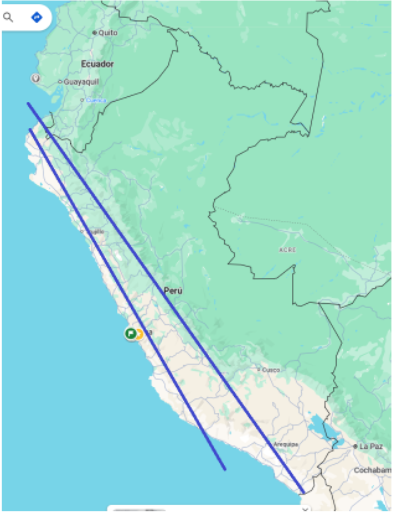

In [236]:
# Div 1
x_0 = (-81.2, -2.9)
x_1 = (-72.6, -17.97)
fun_1, m1, b1 = genera_eq_lat_lon(x_0=x_0, x_1=x_1)

# Div 2
x_0 = (-81, -2.9)
x_1 = (-70, -18)
fun_2, m2, b2 = genera_eq_lat_lon(x_0=x_0, x_1=x_1)


In [237]:
# Lets make sure there are no cutoffs between the regions (in the range of latitudes and longitudes that we are working on)

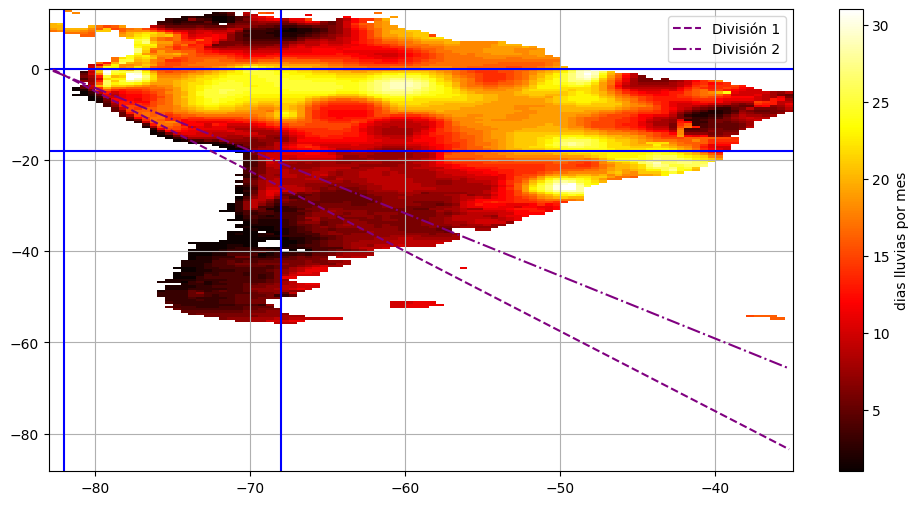

In [238]:
el_new_array_wet = ds_wet_peru_prueba['wet'].values.astype('timedelta64[D]').astype('float')
ds_wet_peru_prueba['wet'].values = np.where(el_new_array_wet<=th_dias, np.nan, el_new_array_wet)


div_1 = fun_1(ds_wet_peru_prueba['lon'].values)
div_2 = fun_2(ds_wet_peru_prueba['lon'].values)

_lon_per, _lat_per = np.meshgrid(ds_wet_peru_prueba['lon'].values,
                                 ds_wet_peru_prueba['lat'].values)
_frs_peru = ds_wet_peru_prueba['wet'].values[-1]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon_per, _lat_per, _frs_peru, shading='auto', cmap='hot')
plt.colorbar(label='dias lluvias por mes')
plt.grid()

# Superior Izquierdo
plt.axvline(x = min_lon, color = 'b')
plt.axhline(y = max_lat, color = 'b')

# Inferior Derecho
plt.axvline(x = max_lon, color = 'b')
plt.axhline(y = min_lat, color = 'b')

plt.plot(ds_wet_peru_prueba['lon'].values, div_1, color='purple', linestyle='--',  label='División 1')
plt.plot(ds_wet_peru_prueba['lon'].values, div_2, color='purple', linestyle='-.', label='División 2')
plt.legend()

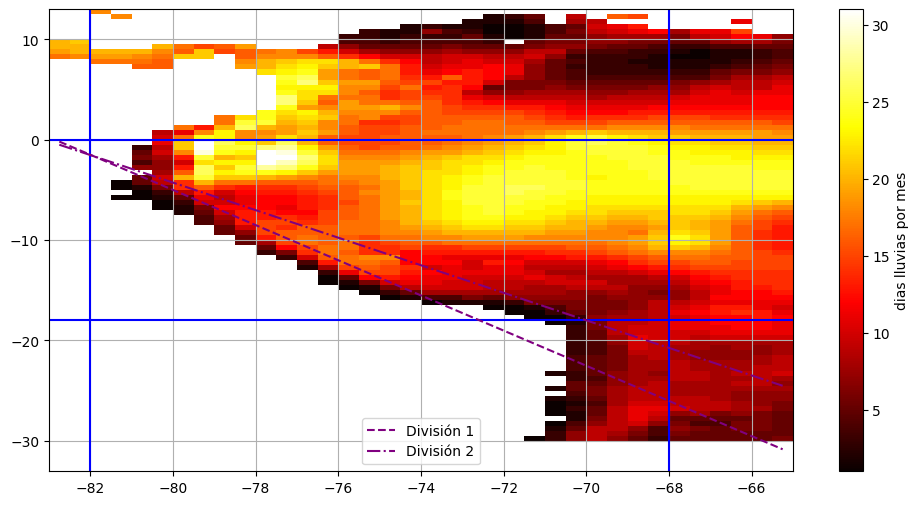

In [239]:
ds_wet_peru_prueba2 = filtrar_por_lat_lon(ds_wet_peru_prueba, (-30, max_lat_LA), (min_lon_LA, -65))


div_1 = fun_1(ds_wet_peru_prueba2['lon'].values)
div_2 = fun_2(ds_wet_peru_prueba2['lon'].values)

_lon_per, _lat_per = np.meshgrid(ds_wet_peru_prueba2['lon'].values,
                                 ds_wet_peru_prueba2['lat'].values)
_frs_peru = ds_wet_peru_prueba2['wet'].values[-1]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon_per, _lat_per, _frs_peru, shading='auto', cmap='hot')
plt.colorbar(label='dias lluvias por mes')
plt.grid()

# Superior Izquierdo
plt.axvline(x = min_lon, color = 'b')
plt.axhline(y = max_lat, color = 'b')

# Inferior Derecho
plt.axvline(x = max_lon, color = 'b')
plt.axhline(y = min_lat, color = 'b')

plt.plot(ds_wet_peru_prueba2['lon'].values, div_1, color='purple', linestyle='--',  label='División 1')
plt.plot(ds_wet_peru_prueba2['lon'].values, div_2, color='purple', linestyle='-.', label='División 2')
plt.legend()

## Aplicar Cuadrantes lineales

In [240]:
consol_df['lat'].value_counts().shape, consol_df['lon'].value_counts().shape

((36,), (28,))

In [241]:
casos = [
    consol_df['lat'] <= fun_1(consol_df['lon']), # Costa
    (consol_df['lat'] > fun_1(consol_df['lon']))&
    (consol_df['lat'] <= fun_2(consol_df['lon'])) # Sierra
         ]
resultados = [0, 0.33]
consol_df['Cuadrante_v1'] = np.select(casos, resultados, default=1) # El default es la selva


casos = [
    consol_df['lat'] <= fun_1(consol_df['lon']) # costa
         ]
resultados = [0]
consol_df['Cuadrante_v2'] = np.select(casos, resultados, default=1) # El Sierra y selva


In [242]:
consol_df['Cuadrante_v1'].value_counts(normalize=True)
# Tiene sentido la proporción de cuadrantes, ya que la mayoría de los puntos están en la selva, luego en la sierra y por último en la costa, pero en este caso la costa nos sale con mayor ptj, pues está incluyendo el mar.

Cuadrante_v1
1.00    0.607143
0.00    0.308532
0.33    0.084325
Name: proportion, dtype: float64

In [243]:
consol_df['Cuadrante_v2'].value_counts(normalize=True)


Cuadrante_v2
1    0.691468
0    0.308532
Name: proportion, dtype: float64

## No lineal

In [244]:
p1 = (-81.2, -2.9)
p2 = (-77, -11)
p3 = (-74, -15)
p4 = (-72, -16)
p5 = (-70, -18)

size_marker_spline = 75
color_marker_spline = 'green'
shape_marker_spline = 'o'

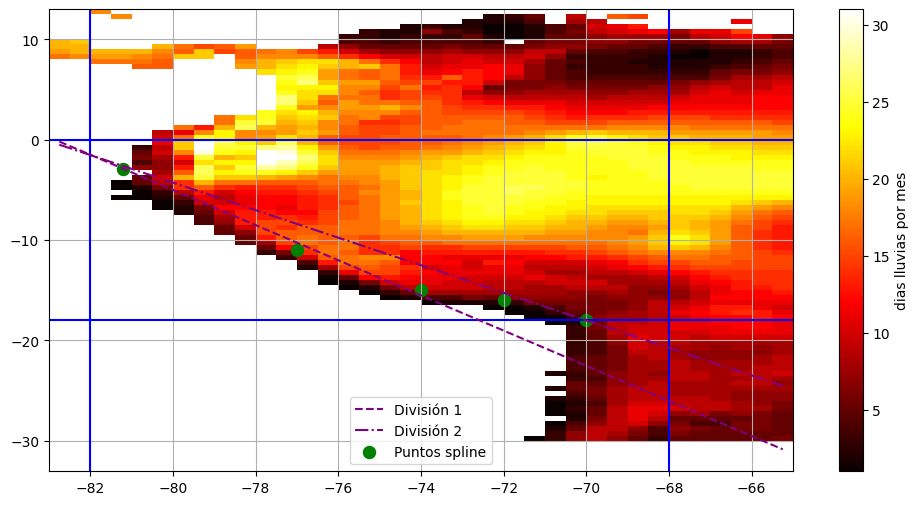

In [245]:
ds_wet_peru_prueba2 = filtrar_por_lat_lon(ds_wet_peru_prueba, (-30, max_lat_LA), (min_lon_LA, -65))


div_1 = fun_1(ds_wet_peru_prueba2['lon'].values)
div_2 = fun_2(ds_wet_peru_prueba2['lon'].values)

_lon_per, _lat_per = np.meshgrid(ds_wet_peru_prueba2['lon'].values,
                                 ds_wet_peru_prueba2['lat'].values)
_frs_peru = ds_wet_peru_prueba2['wet'].values[-1]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon_per, _lat_per, _frs_peru, shading='auto', cmap='hot')
plt.colorbar(label='dias lluvias por mes')
plt.grid()

# Superior Izquierdo
plt.axvline(x = min_lon, color = 'b')
plt.axhline(y = max_lat, color = 'b')

# Inferior Derecho
plt.axvline(x = max_lon, color = 'b')
plt.axhline(y = min_lat, color = 'b')

plt.plot(ds_wet_peru_prueba2['lon'].values, div_1, color='purple', linestyle='--',  label='División 1')
plt.plot(ds_wet_peru_prueba2['lon'].values, div_2, color='purple', linestyle='-.', label='División 2')

# Identificador de primer punto
plt.scatter(x = p1[0], y = p1[1], color = color_marker_spline,marker=shape_marker_spline,  s=size_marker_spline)

# Identificador de segundo punto
plt.scatter(x = p2[0], y = p2[1], color = color_marker_spline,marker=shape_marker_spline,  s=size_marker_spline)

# Identificador de tercer punto
plt.scatter(x = p3[0], y = p3[1], color = color_marker_spline,marker=shape_marker_spline,  s=size_marker_spline)

# Identificador de cuarto punto
plt.scatter(x = p4[0], y = p4[1], color = color_marker_spline,marker=shape_marker_spline,  s=size_marker_spline)

# Identificador de cuarto punto
plt.scatter(x = p5[0], y = p5[1], color = color_marker_spline,marker=shape_marker_spline, label='Puntos spline', s=size_marker_spline)

plt.legend()

In [246]:
def fit_spline_to_points(x, y):
    """
    Ajusta un spline a los puntos dados.
    
    Returns:
        tuple: Coeficientes del spline.
    """
    # Definir los puntos de control
    cs = CubicSpline(x, y)
    return cs

In [247]:
X_y_Y_para_spline = np.array([p1, p2, p3, p4, p5])
X_y_Y_para_spline

array([[-81.2,  -2.9],
       [-77. , -11. ],
       [-74. , -15. ],
       [-72. , -16. ],
       [-70. , -18. ]])

In [248]:
cs = fit_spline_to_points(X_y_Y_para_spline[:, 0], X_y_Y_para_spline[:, 1])

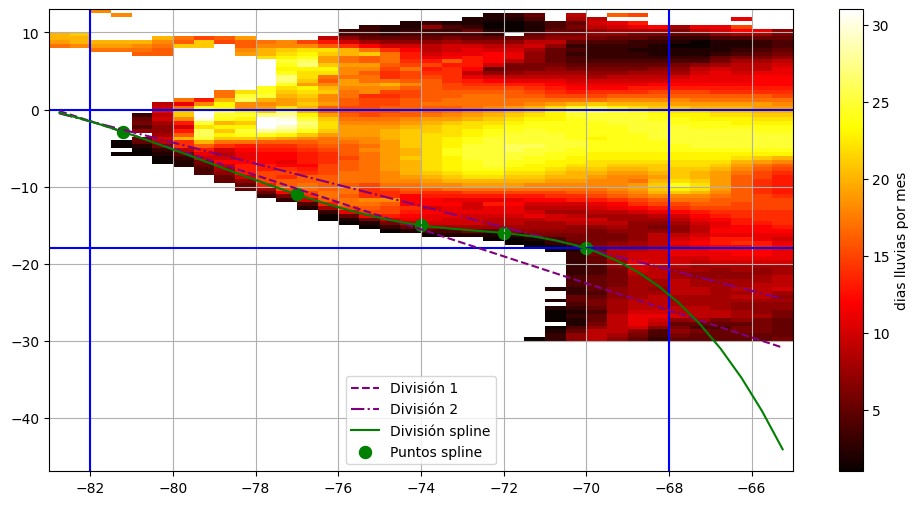

In [249]:
ds_wet_peru_prueba2 = filtrar_por_lat_lon(ds_wet_peru_prueba, (-30, max_lat_LA), (min_lon_LA, -65))


div_1 = fun_1(ds_wet_peru_prueba2['lon'].values)
div_2 = fun_2(ds_wet_peru_prueba2['lon'].values)
div_v2 = cs(ds_wet_peru_prueba2['lon'].values)

_lon_per, _lat_per = np.meshgrid(ds_wet_peru_prueba2['lon'].values,
                                 ds_wet_peru_prueba2['lat'].values)
_frs_peru = ds_wet_peru_prueba2['wet'].values[-1]

plt.figure(figsize=(12, 6))
plt.pcolormesh(_lon_per, _lat_per, _frs_peru, shading='auto', cmap='hot')
plt.colorbar(label='dias lluvias por mes')
plt.grid()

# Superior Izquierdo
plt.axvline(x = min_lon, color = 'b')
plt.axhline(y = max_lat, color = 'b')

# Inferior Derecho
plt.axvline(x = max_lon, color = 'b')
plt.axhline(y = min_lat, color = 'b')

plt.plot(ds_wet_peru_prueba2['lon'].values, div_1, color='purple', linestyle='--',  label='División 1')
plt.plot(ds_wet_peru_prueba2['lon'].values, div_2, color='purple', linestyle='-.', label='División 2')

plt.plot(ds_wet_peru_prueba2['lon'].values, div_v2, color='green', linestyle='-', label='División spline')

# Identificador de primer punto
plt.scatter(x = p1[0], y = p1[1], color = color_marker_spline,marker=shape_marker_spline,  s=size_marker_spline)

# Identificador de segundo punto
plt.scatter(x = p2[0], y = p2[1], color = color_marker_spline,marker=shape_marker_spline,  s=size_marker_spline)

# Identificador de tercer punto
plt.scatter(x = p3[0], y = p3[1], color = color_marker_spline,marker=shape_marker_spline,  s=size_marker_spline)

# Identificador de cuarto punto
plt.scatter(x = p4[0], y = p4[1], color = color_marker_spline,marker=shape_marker_spline,  s=size_marker_spline)

# Identificador de cuarto punto
plt.scatter(x = p5[0], y = p5[1], color = color_marker_spline,marker=shape_marker_spline, label='Puntos spline', s=size_marker_spline)



plt.legend()

## Aplicación no lineal

In [250]:
casos = [
    consol_df['lat'] <= cs(consol_df['lon']) # costa
         ]
resultados = [0]
consol_df['Cuadrante_v3'] = np.select(casos, resultados, default=1) # El Sierra y selva


In [251]:
consol_df['Cuadrante_v3'].value_counts(normalize=True)

Cuadrante_v3
1    0.678571
0    0.321429
Name: proportion, dtype: float64

# Generate Target

En esta sección podemos mejorar la transformación del target por algo más complejo, algo que tenga en cuenta la altura de las zonas cercanas, etc.

Acá lo que hacemos es, en una ventana movil de T años (en principio deberían ser aprox 10 años por la recurrencia del FEN), selecciónamos el q% max de lluvias por cuadrante. Sobre la generación de cuadrantes, ver la anterior sección.

Usamos cuadrantes porque no queremos comprar zonas que per-se son lluviosas con zonas que tienen menos lluvias, pues siempre saldrán como target=1 la zona que por naturaleza tiene más lluivas. Por ejemplo, la costa nunca tendrá 1s, pues la selva se los llevará todos.

In [252]:
consol_df.groupby('Cuadrante_v1')['wet'].describe()

,count,mean,std,min,25%,50%,75%,max
Cuadrante_v1,,,,,,,,
0.00,82230.0,5.104804,4.767826,1.0,2.0,3.0,7.0,31.0
0.33,99440.0,9.148944,6.696915,1.0,3.0,8.0,13.0,31.0
1.00,884848.0,15.164303,6.677273,1.0,10.0,16.0,20.0,31.0


<Axes: xlabel='wet', ylabel='Density'>

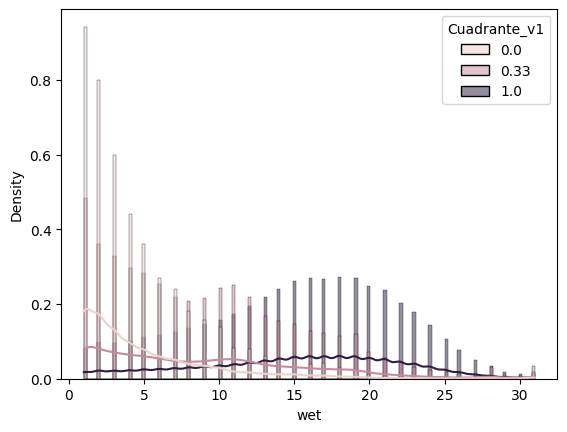

In [253]:
sns.histplot(data=consol_df, x='wet', hue='Cuadrante_v1', kde=True, stat='density', common_norm=False)

In [254]:
consol_df.groupby('Cuadrante_v2')['wet'].describe()

,count,mean,std,min,25%,50%,75%,max
Cuadrante_v2,,,,,,,,
0,82230.0,5.104804,4.767826,1.0,2.0,3.0,7.0,31.0
1,984288.0,14.556587,6.920895,1.0,9.0,15.0,20.0,31.0


<Axes: xlabel='wet', ylabel='Density'>

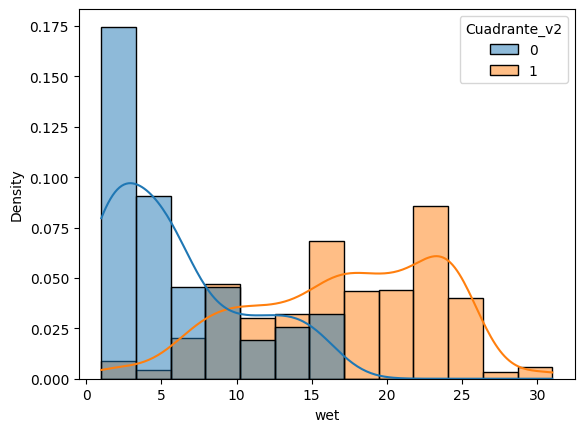

In [255]:
sns.histplot(data=consol_df[consol_df['CODMES']==202412], x='wet', hue='Cuadrante_v2', kde=True, stat='density', common_norm=False)

In [256]:
consol_df.groupby('Cuadrante_v3')['wet'].describe()

,count,mean,std,min,25%,50%,75%,max
Cuadrante_v3,,,,,,,,
0,82754.0,4.296481,4.106789,1.0,2.0,3.0,6.0,31.0
1,983764.0,14.629617,6.856560,1.0,10.0,15.0,20.0,31.0


<Axes: xlabel='wet', ylabel='Density'>

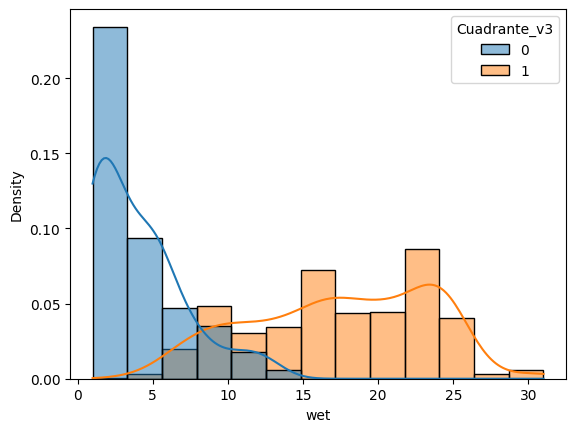

In [257]:
sns.histplot(data=consol_df[consol_df['CODMES']==202412], x='wet', hue='Cuadrante_v3', kde=True, stat='density', common_norm=False)

In [ ]:
wind_size_yr = 10
min_codmes = consol_df['CODMES'].min()
max_codmes = consol_df['CODMES'].max()

In [259]:
consol_df_bk = consol_df.copy()

In [278]:
consol_df = consol_df_bk.copy()

In [279]:
# Definición de los meses inicial y final para el Rolling Window
desde_codmes_rw = min_codmes
hasta_codmes_rw = add_months_to_date(min_codmes, wind_size_yr*12)
cuadrante_x_usar = 'Cuadrante_v3'
th_usar = 0.95

# Inicializamos a todos con 0
consol_df['mi_Y'] = 0
consol_df['el_th_usado'] = np.nan

guardado_ths = pd.DataFrame()
en_rango_df = True
while en_rango_df:
    th_valor = consol_df[consol_df['CODMES'].between(desde_codmes_rw, hasta_codmes_rw)].groupby([cuadrante_x_usar])['wet'].quantile(th_usar)
    
    th_valor.rename('_th', inplace = True)
    consol_df = pd.merge(consol_df, th_valor, on = cuadrante_x_usar)

    # Si en algún momento ya lo marqué como "1", si en el futuro ya no cumple la condición, igual está marcado
    consol_df['mi_Y'] = np.where(
                    ((consol_df['CODMES'].between(desde_codmes_rw, hasta_codmes_rw))&
                    (consol_df['wet']>=consol_df['_th'])), 
                    1, consol_df['mi_Y'])
    
    # Guardamos el th que generó que sea target=1, no se hace ovewrite
    consol_df['el_th_usado'] = np.where(
                ((consol_df['CODMES'].between(desde_codmes_rw, hasta_codmes_rw))&
                (consol_df['wet']>=consol_df['_th'])), 
                consol_df['_th'], consol_df['el_th_usado'])
    
    # Dropeamos la columna para la siguiente iteración
    consol_df.drop('_th', axis=1, inplace=True)

    # Guardamos la data de los th usados 
    th_valor = th_valor.reset_index()
    th_valor['CODMES_DESDE'] = desde_codmes_rw
    th_valor['CODMES_HASTA'] = hasta_codmes_rw
    guardado_ths = pd.concat([guardado_ths, th_valor])


    # Movemos el rolling window
    desde_codmes_rw = add_months_to_date(desde_codmes_rw, 1)
    hasta_codmes_rw = add_months_to_date(hasta_codmes_rw, 1)
    if hasta_codmes_rw>max_codmes:
        en_rango_df = False




## Target validation

In [280]:
consol_df.groupby(['Cuadrante_v3'])['mi_Y'].describe(percentiles=[0.9,0.95, 0.99, 0.998, 0.999])

,count,mean,std,min,50%,90%,95%,99%,99.8%,99.9%,max
Cuadrante_v3,,,,,,,,,,,
0,482112.0,0.011091,0.104727,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1017792.0,0.072099,0.258652,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
guardado_ths['CODMES_DESDE_D'] = pd.to_datetime(guardado_ths['CODMES_DESDE'], format='%Y%m')
guardado_ths['CODMES_HASTA_D'] = pd.to_datetime(guardado_ths['CODMES_HASTA'], format='%Y%m')

Text(0.5, 1.0, 'Th usados por mes')

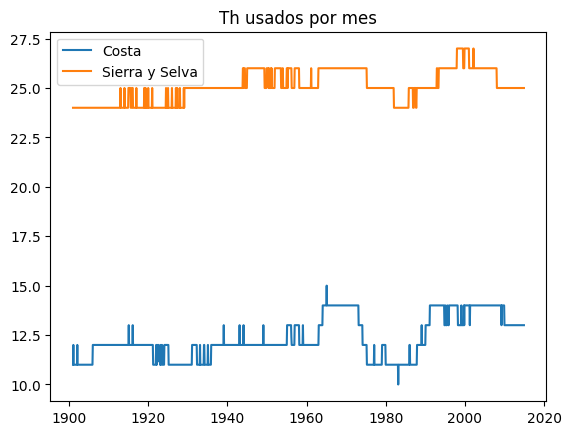

In [ ]:
fig, ax = plt.subplots()
ax.plot(guardado_ths[guardado_ths['Cuadrante_v3']==0]['CODMES_DESDE_D'], guardado_ths[guardado_ths['Cuadrante_v3']==0]['_th'], label='Costa')
ax.plot(guardado_ths[guardado_ths['Cuadrante_v3']==1]['CODMES_DESDE_D'], guardado_ths[guardado_ths['Cuadrante_v3']==1]['_th'], label='Sierra y Selva')
ax.legend()
plt.title('Th usados por mes')

Nos aseguramos que el th usado sea estable en el tiempo, que sea diferenciado entre las 2 regiones y, en caso sea necesario (2017) el th se acomode a niveles más altos.

In [295]:
consol_df['CODMES_D'] = pd.to_datetime(consol_df['CODMES'], format='%Y%m')

In [302]:
consol_df_grp = consol_df.groupby(['CODMES_D', 'mi_Y', 'Cuadrante_v3'])['wet'].agg(['mean', 'sum', 'count']).reset_index()
consol_df_grp.head()

,CODMES_D,mi_Y,Cuadrante_v3,mean,sum,count
0,1901-01-01,0,0,4.301587,271.0,63
1,1901-01-01,0,1,15.827324,8341.0,527
2,1901-01-01,1,0,13.166667,79.0,6
3,1901-01-01,1,1,25.569444,3682.0,144
4,1901-02-01,0,0,5.785714,324.0,56


Text(0.5, 0.98, 'Mean Wet Level by Region')

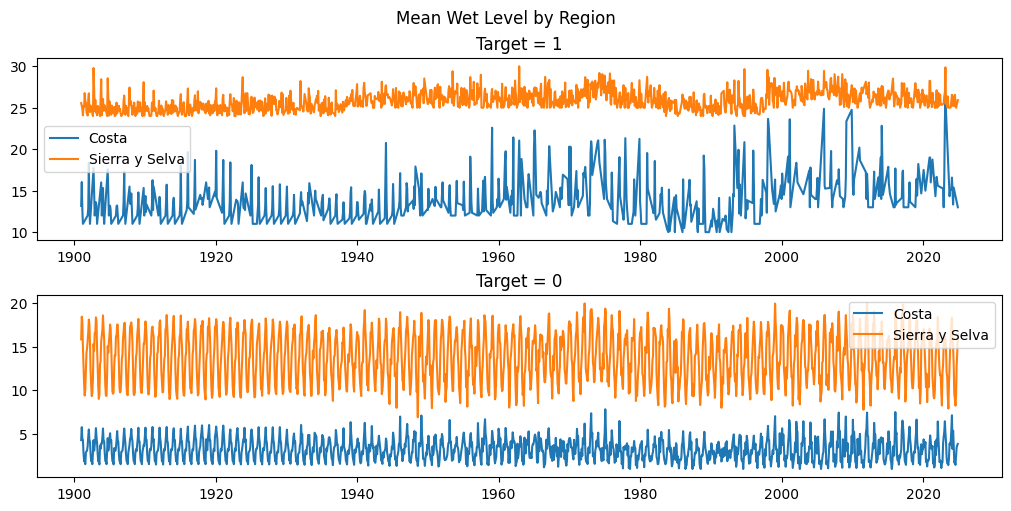

In [323]:
mask_target = consol_df_grp['mi_Y']==1
mask_costa = consol_df_grp['Cuadrante_v3']==0

fig, ax = plt.subplots(2,1, figsize=(10, 5), layout = 'constrained')
ax[0].plot(consol_df_grp[mask_target&mask_costa]['CODMES_D'], consol_df_grp[mask_target&mask_costa]['mean'],  label='Costa')
ax[0].plot(consol_df_grp[mask_target&~mask_costa]['CODMES_D'], consol_df_grp[mask_target&~mask_costa]['mean'],  label='Sierra y Selva')
ax[0].legend()
ax[0].set_title("Target = 1")


ax[1].plot(consol_df_grp[~mask_target&mask_costa]['CODMES_D'], consol_df_grp[~mask_target&mask_costa]['mean'],  label='Costa')
ax[1].plot(consol_df_grp[~mask_target&~mask_costa]['CODMES_D'], consol_df_grp[~mask_target&~mask_costa]['mean'],  label='Sierra y Selva')
ax[1].legend()
ax[1].set_title("Target = 0")

plt.suptitle('Mean Wet Level by Region')

Consistencia entre regiones, en el siguiente plot revisamos consistencia within regions

Text(0.5, 0.98, 'Mean Wet Level by Target')

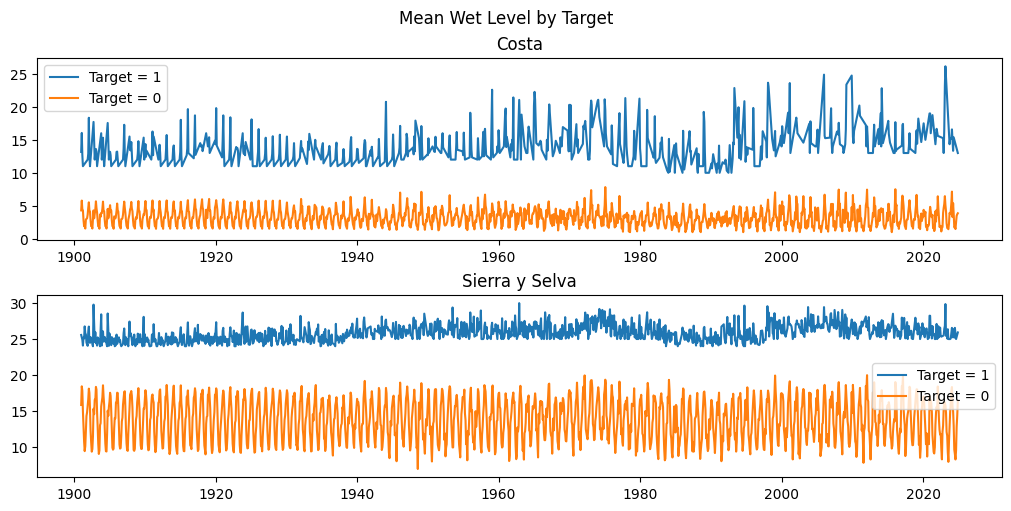

In [325]:
fig, ax = plt.subplots(2,1, figsize=(10, 5), layout = 'constrained')
ax[0].plot(consol_df_grp[mask_target&mask_costa]['CODMES_D'], consol_df_grp[mask_target&mask_costa]['mean'],  label='Target = 1')
ax[0].plot(consol_df_grp[~mask_target&mask_costa]['CODMES_D'], consol_df_grp[~mask_target&mask_costa]['mean'],  label='Target = 0')
ax[0].legend()
ax[0].set_title("Costa")


ax[1].plot(consol_df_grp[mask_target&~mask_costa]['CODMES_D'], consol_df_grp[mask_target&~mask_costa]['mean'],  label='Target = 1')
ax[1].plot(consol_df_grp[~mask_target&~mask_costa]['CODMES_D'], consol_df_grp[~mask_target&~mask_costa]['mean'],  label='Target = 0')
ax[1].legend()
ax[1].set_title("Sierra y Selva")

plt.suptitle('Mean Wet Level by Target')

In [333]:
consol_df_grp_2 = consol_df_grp.groupby(['CODMES_D', 'mi_Y'])['count'].sum().reset_index()
consol_df_grp_2.sample(5)

,CODMES_D,mi_Y,count
939,1942-08-01,1,17
1746,1978-05-01,1,97
2150,1996-04-01,0,715
1352,1961-04-01,1,17
1272,1957-09-01,1,3


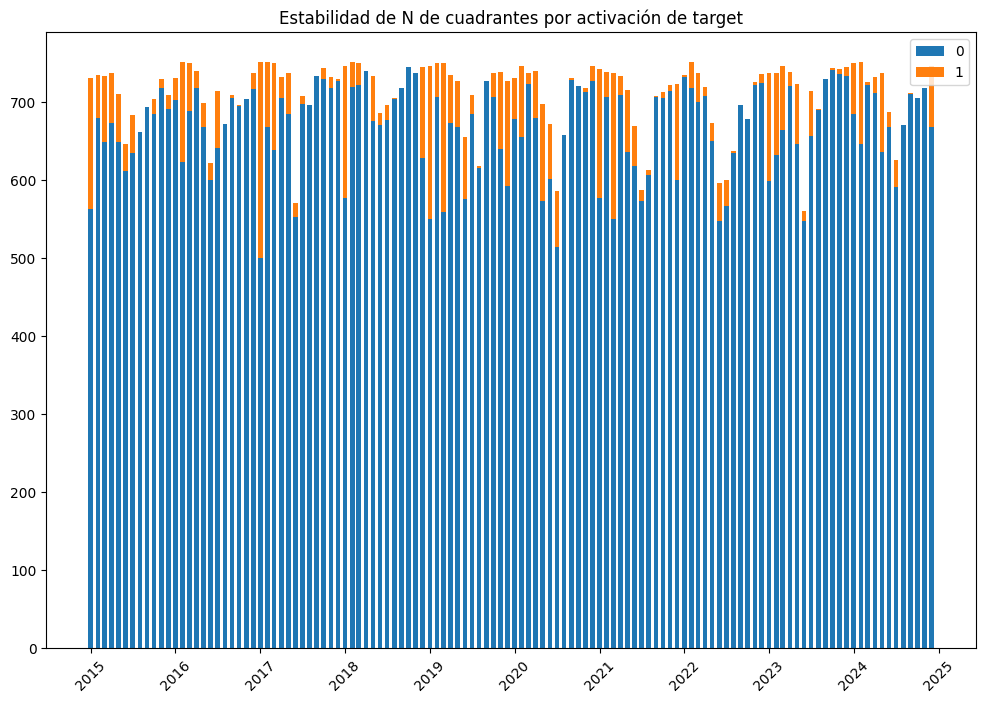

In [342]:
stackedplot_agg(df = consol_df_grp_2[consol_df_grp_2['CODMES_D'].between('2015-01-01', '2025-01-01')],
                freq = 'CODMES_D',
                var1 = 'mi_Y',
                values = 'count',
                width=20, rotation=45,
                title = 'Estabilidad de N de cuadrantes por activación de target')

In [343]:
consol_df

,lon,lat,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet,CODMES,Cuadrante_v1,Cuadrante_v2,Cuadrante_v3,mi_Y,el_th_usado,CODMES_D
0,-81.75,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN,1901-01-01
1,-81.25,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN,1901-01-01
2,-80.75,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN,1901-01-01
3,-80.25,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN,1901-01-01
4,-79.75,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN,1901-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499899,-70.25,-0.25,87.599998,9.3,NaN,2.7,231.500000,22.700001,27.300001,32.000000,30.300001,25.0,202412,1.0,1,1,1,25.0,2024-12-01
1499900,-69.75,-0.25,91.900002,9.2,NaN,2.4,252.400009,21.900000,26.500000,31.100000,30.200001,26.0,202412,1.0,1,1,1,25.0,2024-12-01
1499901,-69.25,-0.25,96.700005,9.2,NaN,2.3,277.000000,21.800001,26.400000,31.000000,30.400000,25.0,202412,1.0,1,1,1,25.0,2024-12-01
1499902,-68.75,-0.25,97.900002,9.2,NaN,2.2,300.600006,21.900000,26.500000,31.100000,30.900000,24.0,202412,1.0,1,1,0,NaN,2024-12-01


# Generate Base File

In [344]:
consol_df.drop('CODMES_D', axis=1).to_csv(el_path_main/'2. Datos/Main gridded data/consol_df_peru.csv', index=False)

In [75]:
# El drop na, la normalización de los datos y fill na se harán en el siguiente notebook
# Haremos un dropna de las zonas en que [lat, lon] no tienen información de al menos una variable (el mar)

# La generación grafos se podría hacer en base a una combinación de variables:
# - distancia entre puntos (lat, lon)
# - distancia temporal entre puntos (meses)

# Transform into Conv TS

In [76]:
# Para este caso no haremos dropna a nada, por lo que el filla na y normalización la haremos de otra forma

In [77]:
def generate_Conv_TS(df, var_name, lat_name, long_name, time_name, n_lags=12, dif_y_X = 12):
    """
    Genera una serie temporal de convolución para una variable específica.
    
    Args:
        df (pd.DataFrame): DataFrame con las columnas de latitud, longitud, tiempo y la variable.
        var_name (str): Nombre de la variable a analizar.
        lat_name (str): Nombre de la columna de latitud.
        long_name (str): Nombre de la columna de longitud.
        time_name (str): Nombre de la columna de tiempo.
        n_lags (int): Número de lags a considerar para la relación de serie de tiempo.
        n_dif_y_X (int): Número de meses entre la variable objetivo y las variables predictoras.
    Returns:
        X: np.array: Numpy Array X
        y: np.array: Numpy Array y
    """

    
    return X, y